# Day 5 - Solved Analysis Problems
## Analysis of patch-clamp data from ./patch_data_2024 folder

This notebook contains the complete analysis with solutions to all exercises.


In [1]:
import os
import glob
import numpy as np
import pandas as pd

# Import ABF files library
import pyabf

# Find Peaks and signal processing
import scipy
from scipy import signal
from scipy.signal import find_peaks

# Plots
import matplotlib.pyplot as plt

plt.close('all')


## 1. Load ABF Files from patch_data_2024 folder


In [2]:
# Define the data folder
data_folder = './patch_data_2024'

# Find all ABF files in the folder
abf_files = glob.glob(os.path.join(data_folder, '*.abf'))

print(f"Found {len(abf_files)} ABF file(s):")
for file in abf_files:
    print(f"  - {os.path.basename(file)}")


Found 2 ABF file(s):
  - Spike recording.abf
  - CheRiff current.abf


## 2. Load and explore a single ABF file (Spike recording -- Current clamp on a "Spiking HEK cell")
**Important:** Recording modes and units:
- **Voltage Clamp**: Records current (pA, nA)
- **Current Clamp**: Records voltage (mV, V)


In [3]:
# Select which file to load - you can change the filename here
# Options: "Spike recording.abf" or "CheRiff current.abf"
filename_to_load = "Spike recording.abf"  # Change this to select different file

if len(abf_files) > 0:
    # Find the file with the specified name
    selected_file = None
    for file in abf_files:
        if os.path.basename(file) == filename_to_load:
            selected_file = file
            break
    
    if selected_file is None:
        print(f"Error: Could not find file '{filename_to_load}'")
        print("Available files:")
        for file in abf_files:
            print(f"  - {os.path.basename(file)}")
    else:
        print(f"Loading: {os.path.basename(selected_file)}")
        
        # Load the ABF file
        abf = pyabf.ABF(selected_file)
        
        # Print basic information
        print(f"\nFile Information:")
        print(f"  Sampling rate: {abf.dataRate} Hz")
        print(f"  Number of sweeps: {abf.sweepCount}")
        print(f"  Number of channels: {abf.channelCount}")
        print(f"  Duration: {abf.sweepLengthSec} seconds per sweep")
        print(f"  Y-axis label (from file): {abf.sweepLabelY}")
        print(f"  Y-axis units (from file): {abf.sweepUnitsY}")
        print(f"  X-axis label: {abf.sweepLabelX}")
        
        # CORRECTION: Override incorrect labels for "Spike recording.abf"
        if "Spike" in os.path.basename(selected_file):
            print(f"\n  ⚠️  CORRECTING METADATA:")
            print(f"  This is Current Clamp (measuring voltage), not Voltage Clamp")
            print(f"  Overriding Y-axis label to: Membrane Potential (mV)")
            # Store corrected labels
            correct_label = "Membrane Potential (mV)"
            correct_units = "mV"
            recording_mode = "CURRENT CLAMP (measuring voltage)"
        else:
            # Use original labels
            correct_label = abf.sweepLabelY
            correct_units = abf.sweepUnitsY
            # Identify recording mode
            if abf.sweepUnitsY in ['pA', 'nA', 'A', 'µA', 'uA']:
                recording_mode = "VOLTAGE CLAMP (measuring current)"
            elif abf.sweepUnitsY in ['mV', 'V', 'µV', 'uV']:
                recording_mode = "CURRENT CLAMP (measuring voltage)"
            else:
                recording_mode = f"Unknown ({abf.sweepUnitsY})"
        
        print(f"  Recording mode: {recording_mode}")
else:
    print("No ABF files found in the folder!")


Loading: Spike recording.abf

File Information:
  Sampling rate: 10000 Hz
  Number of sweeps: 50
  Number of channels: 3
  Duration: 1.0 seconds per sweep
  Y-axis label (from file): Clamp Current (pA)
  Y-axis units (from file): pA
  X-axis label: Time (seconds)

  ⚠️  CORRECTING METADATA:
  This is Current Clamp (measuring voltage), not Voltage Clamp
  Overriding Y-axis label to: Membrane Potential (mV)
  Recording mode: CURRENT CLAMP (measuring voltage)


## 3. Plot all sweeps from the selected file


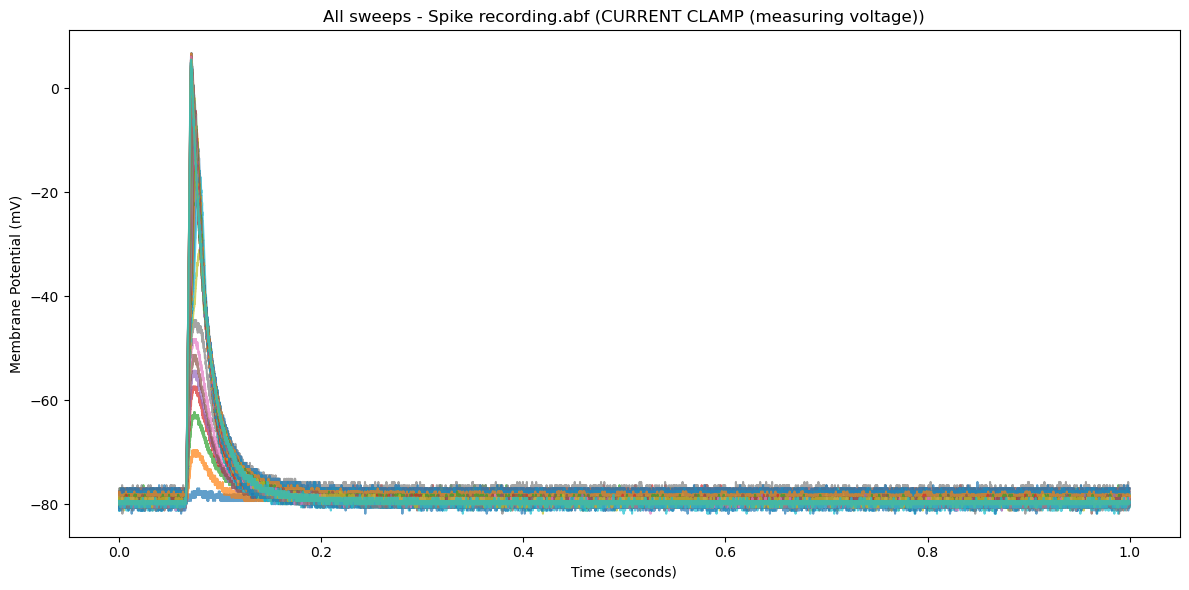

In [4]:
# Plot all sweeps in the ABF file (with corrected labels)
if selected_file is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        time = abf.sweepX
        y_variable = abf.sweepY
        
        # Plot each sweep
        ax.plot(time, y_variable, alpha=0.7, label=f'Sweep {sweepNumber}')
    
    # Use corrected label instead of abf.sweepLabelY
    ax.set_ylabel(correct_label)
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_title(f'All sweeps - {os.path.basename(selected_file)} ({recording_mode})')
    
    # Add legend if there are multiple sweeps
    if abf.sweepCount > 1 and abf.sweepCount <= 10:
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No file loaded. Please run the previous cell first.")


### 3.1. SOLUTION: Find the max amplitude and plot as a function of sweep number and Irradiance

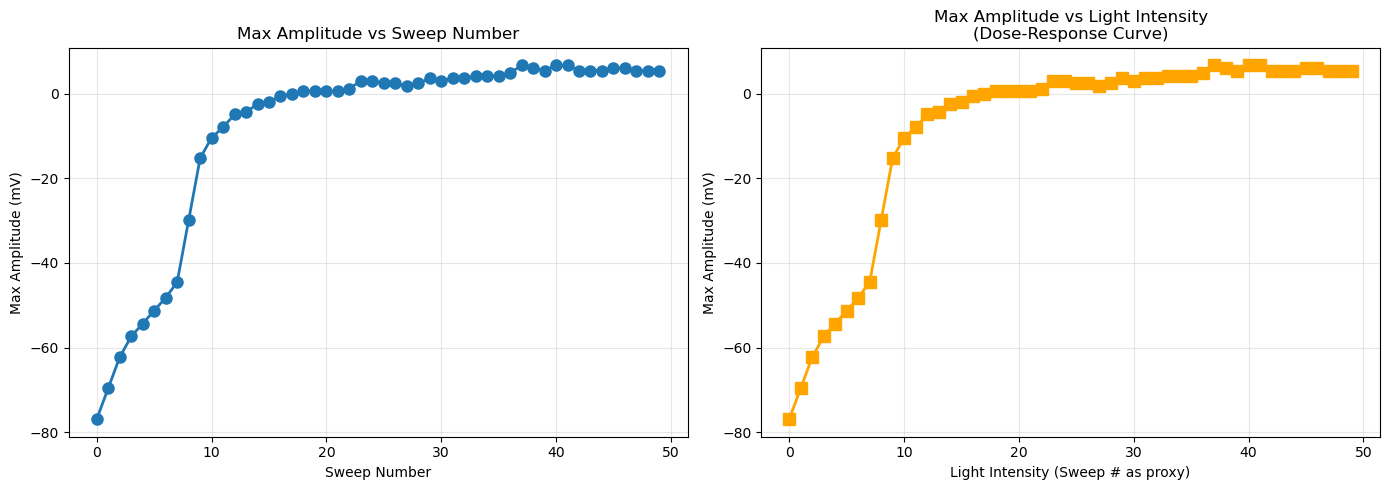


Max Amplitude Statistics:
  Overall Max: 6.71 mV
  Overall Min: -76.90 mV
  Mean: -8.29 mV
  Std Dev: 22.96 mV


In [5]:
# Calculate maximum amplitude for each sweep
if selected_file is not None:
    max_amplitudes = []
    sweep_numbers = []
    
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        # For current clamp (measuring voltage), find the maximum value
        max_amp = np.max(abf.sweepY)
        max_amplitudes.append(max_amp)
        sweep_numbers.append(sweepNumber)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Max amplitude vs sweep number
    ax1.plot(sweep_numbers, max_amplitudes, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Sweep Number')
    ax1.set_ylabel(f'Max Amplitude ({correct_units})')
    ax1.set_title('Max Amplitude vs Sweep Number')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Max amplitude vs Light intensity (sweep number as proxy for irradiance)
    # In this recording, each sweep represents increasing light intensity
    ax2.plot(sweep_numbers, max_amplitudes, 's-', linewidth=2, markersize=8, color='orange')
    ax2.set_xlabel('Light Intensity (Sweep # as proxy)')
    ax2.set_ylabel(f'Max Amplitude ({correct_units})')
    ax2.set_title('Max Amplitude vs Light Intensity\n(Dose-Response Curve)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nMax Amplitude Statistics:")
    print(f"  Overall Max: {np.max(max_amplitudes):.2f} {correct_units}")
    print(f"  Overall Min: {np.min(max_amplitudes):.2f} {correct_units}")
    print(f"  Mean: {np.mean(max_amplitudes):.2f} {correct_units}")
    print(f"  Std Dev: {np.std(max_amplitudes):.2f} {correct_units}")


### 3.2. SOLUTION: Create a phase-plot for these traces

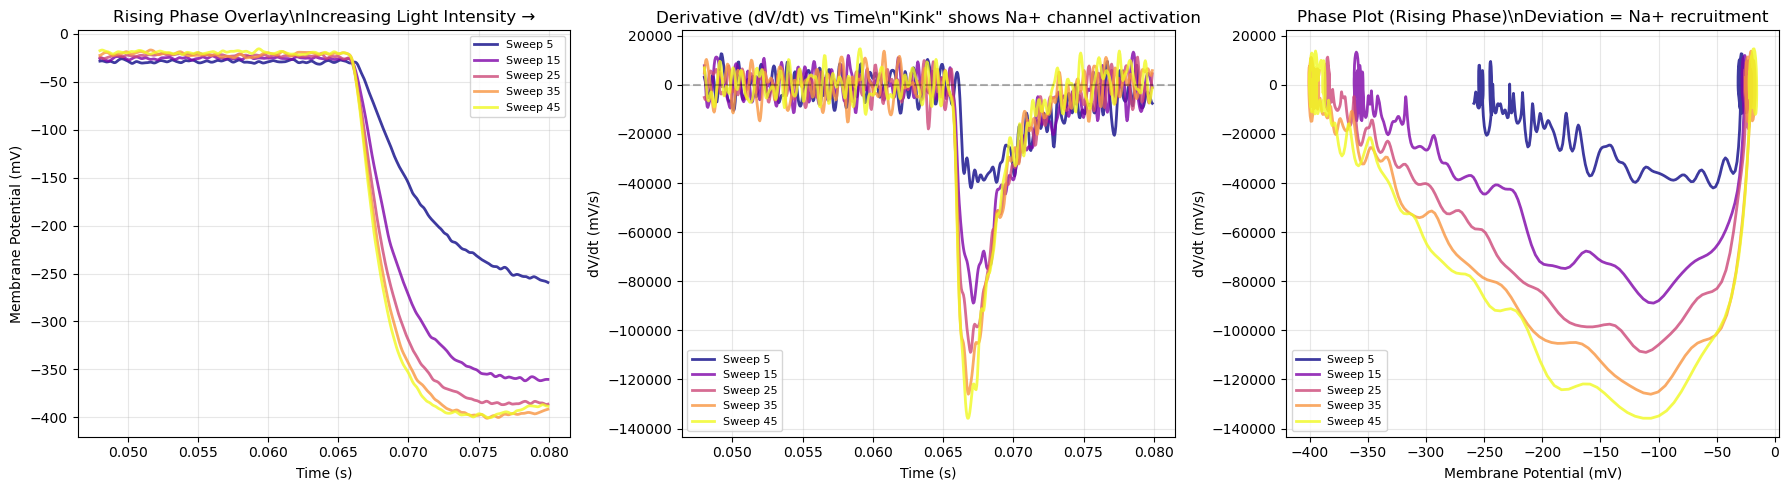

Interpretation - Sodium Channel Recruitment:
LOW intensity sweeps (blue/purple):
  • Smooth rising phase = only ChETA/CheRiff photocurrent
  • Gradual, linear increase in dV/dt

HIGH intensity sweeps (yellow/white):
  • 'Kink' in rising phase = voltage-gated Na+ channels activate!
  • Sudden acceleration in dV/dt (visible in middle plot)
  • Phase plot shows sharp upward deviation

The transition from smooth to kinked responses shows the
threshold for activating endogenous voltage-gated sodium channels.

Tip: Look for the sudden increase in slope (dV/dt) in the middle plot!


In [18]:
# Visualizing Sodium Channel Recruitment
# Goal: Show the "kink" in the rising phase when Na+ channels are recruited
# This happens when light-induced depolarization reaches threshold for voltage-gated Na+ channels

if selected_file is not None:
    # Select sweeps to compare (low, medium, and high light intensity)
    sweeps_to_compare = [5, 15, 25, 35, 45]  # Increasing light intensity
    
    # Focus on the rising phase of the response (adjust based on your protocol)
    time_start = 0.048  # Just before light onset
    time_end = 0.08     # During rising phase
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Storage for phase plot data
    colors = plt.cm.plasma(np.linspace(0, 1, len(sweeps_to_compare)))
    
    # CRITICAL: Filter signal before taking derivative to avoid noise amplification!
    # Create filter coefficients
    fs = abf.dataRate
    b_low, a_low = signal.bessel(4, 2000, 'low', analog=False, norm='phase', fs=fs)
    
    for idx, sweep in enumerate(sweeps_to_compare):
        abf.setSweep(sweep)
        time_full = abf.sweepX
        y_full = abf.sweepY
        
        # **IMPORTANT**: Filter BEFORE taking derivative!
        y_full_filtered = signal.filtfilt(b_low, a_low, y_full)
        
        # Extract rising phase segment from FILTERED signal
        idx_start = np.argmin(np.abs(time_full - time_start))
        idx_end = np.argmin(np.abs(time_full - time_end))
        
        time_segment = time_full[idx_start:idx_end]
        y_segment = y_full_filtered[idx_start:idx_end]  # Use filtered signal!
        
        # Calculate derivative on the FILTERED signal
        dt = 1 / abf.dataRate
        dy_dt = np.diff(y_segment) / dt
        y_aligned = y_segment[:-1]
        
        # Plot 1: Rising phase overlay (voltage vs time)
        ax1.plot(time_segment, y_segment, linewidth=2, color=colors[idx], 
                 label=f'Sweep {sweep}', alpha=0.8)
        
        # Plot 2: dV/dt vs time (derivative shows the kink clearly)
        time_aligned = time_segment[:-1]
        ax2.plot(time_aligned, dy_dt, linewidth=2, color=colors[idx], 
                 label=f'Sweep {sweep}', alpha=0.8)
        
        # Plot 3: Phase plot (dV/dt vs V) - shows recruitment as deviation from smooth curve
        ax3.plot(y_aligned, dy_dt, linewidth=2, color=colors[idx], 
                 label=f'Sweep {sweep}', alpha=0.8)
    
    # Configure Plot 1
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(correct_label)
    ax1.set_title('Rising Phase Overlay\\nIncreasing Light Intensity →')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=8)
    
    # Configure Plot 2
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(f'dV/dt ({correct_units}/s)')
    ax2.set_title('Derivative (dV/dt) vs Time\\n"Kink" shows Na+ channel activation')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=8)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Configure Plot 3
    ax3.set_xlabel(correct_label)
    ax3.set_ylabel(f'dV/dt ({correct_units}/s)')
    ax3.set_title('Phase Plot (Rising Phase)\\nDeviation = Na+ recruitment')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("Interpretation - Sodium Channel Recruitment:")
    print("=" * 60)
    print("LOW intensity sweeps (blue/purple):")
    print("  • Smooth rising phase = only ChETA/CheRiff photocurrent")
    print("  • Gradual, linear increase in dV/dt")
    print("")
    print("HIGH intensity sweeps (yellow/white):")
    print("  • 'Kink' in rising phase = voltage-gated Na+ channels activate!")
    print("  • Sudden acceleration in dV/dt (visible in middle plot)")
    print("  • Phase plot shows sharp upward deviation")
    print("")
    print("The transition from smooth to kinked responses shows the")
    print("threshold for activating endogenous voltage-gated sodium channels.")
    print("")
    print("Tip: Look for the sudden increase in slope (dV/dt) in the middle plot!")


## 4. Plot individual sweep with filtering (optional)


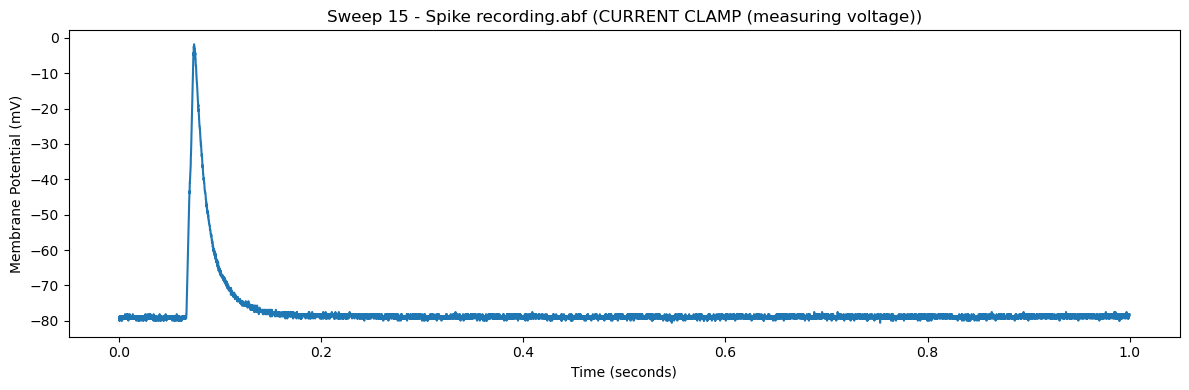

In [7]:
# Select a specific sweep to analyze
if selected_file is not None:
    sweep_to_plot = 15  # Change this to select different sweeps
    
    abf.setSweep(sweep_to_plot)
    time = abf.sweepX
    y_variable = abf.sweepY
    fs = abf.dataRate
    
    # Optional: Apply lowpass Bessel filter
    apply_filter = False  # Set to False to disable filtering
    
    if apply_filter:
        b_lowpass, a_lowpass = signal.bessel(
            4,        # Order of the filter
            2000,     # Cutoff frequency (adjust as needed)
            'low',    # Type of filter
            analog=False,
            norm='phase',
            fs=fs
        )
        signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, y_variable)
    else:
        signal_filtered = y_variable
    
    # Plot (with corrected labels)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, signal_filtered)
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_ylabel(correct_label)  # Use corrected label
    ax.set_title(f'Sweep {sweep_to_plot} - {os.path.basename(selected_file)} ({recording_mode})')
    
    plt.tight_layout()
    plt.show()
else:
    print("No file loaded. Please run the file loading cell first.")


## 5. Spike/Peak Detection


Detected 0 peaks


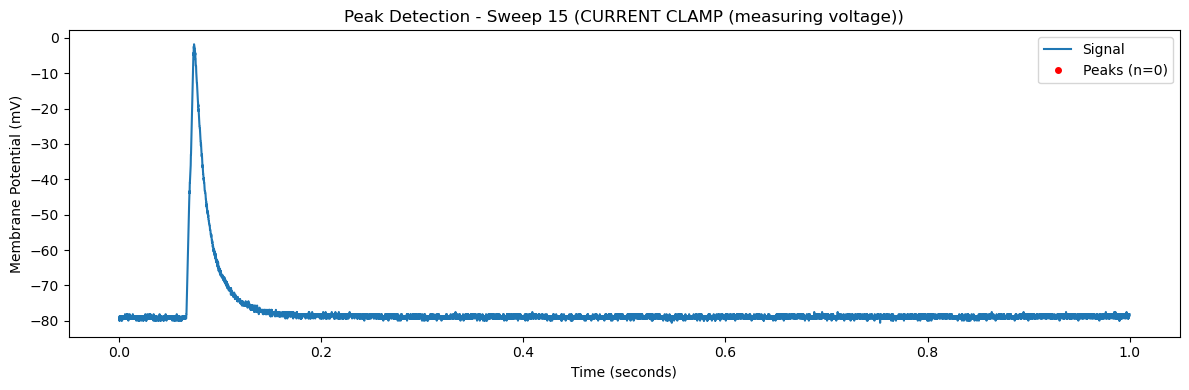

In [8]:
# Peak detection parameters
if len(abf_files) > 0:
    # Threshold for peak detection (adjust based on your data)
    peaks_threshold = 20  # Adjust this value
    detect_negative_peaks = False  # Set to True for negative peaks
    
    # Prepare signal for peak detection
    if detect_negative_peaks:
        signal_for_peaks = -signal_filtered
    else:
        signal_for_peaks = signal_filtered
    
    # Find peaks
    peaks, peaks_dict = find_peaks(signal_for_peaks, height=peaks_threshold)
    
    print(f"Detected {len(peaks)} peaks")
    
    # Plot with detected peaks (with corrected labels)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, signal_filtered, label='Signal')
    ax.plot(time[peaks], signal_filtered[peaks], "r.", markersize=8, label=f'Peaks (n={len(peaks)})')
    
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_ylabel(correct_label)  # Use corrected label
    ax.set_title(f'Peak Detection - Sweep {sweep_to_plot} ({recording_mode})')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


## 6. Load and explore a Voltage Clamp recording (CheRiff photocurrents)
**Important reminder:** Recording modes and units:
- **Voltage Clamp**: Records current (pA, nA)
- **Current Clamp**: Records voltage (mV, V)



Loading: CheRiff current.abf

File Information:
  Sampling rate: 20000 Hz
  Number of sweeps: 50
  Duration: 1.0 seconds per sweep
  Y-axis label (from file): Clamp Current (pA)
  Y-axis units (from file): pA
  Recording mode: VOLTAGE CLAMP (current)
  Corrected Y-axis label: Current (pA)


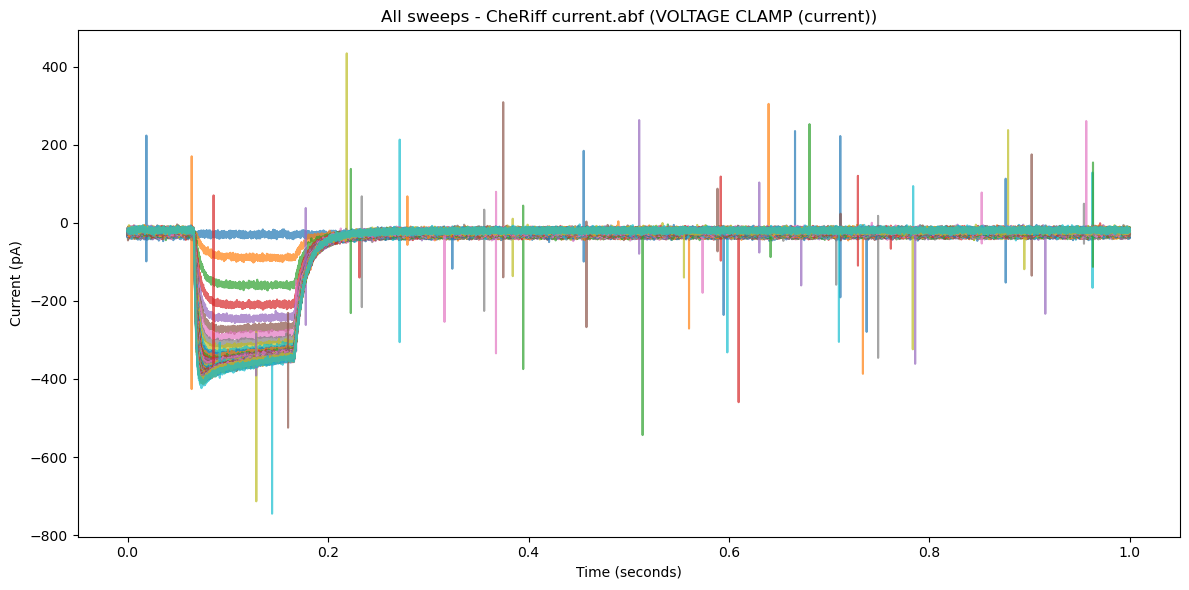

In [9]:
# Load and plot CheRiff current.abf file (all sweeps overlapped)
cheriff_filename = "CheRiff current.abf"

if len(abf_files) > 0:
    # Find the CheRiff file
    cheriff_file = None
    for file in abf_files:
        if os.path.basename(file) == cheriff_filename:
            cheriff_file = file
            break
    
    if cheriff_file is None:
        print(f"Error: Could not find file '{cheriff_filename}'")
        print("Available files:", [os.path.basename(f) for f in abf_files])
    else:
        print(f"Loading: {os.path.basename(cheriff_file)}")
        
        # Load the ABF file
        abf_cheriff = pyabf.ABF(cheriff_file)
        
        # Print basic information
        print(f"\nFile Information:")
        print(f"  Sampling rate: {abf_cheriff.dataRate} Hz")
        print(f"  Number of sweeps: {abf_cheriff.sweepCount}")
        print(f"  Duration: {abf_cheriff.sweepLengthSec} seconds per sweep")
        print(f"  Y-axis label (from file): {abf_cheriff.sweepLabelY}")
        print(f"  Y-axis units (from file): {abf_cheriff.sweepUnitsY}")
        
        # CORRECTION: Override label for voltage clamp recording
        cheriff_mode = "VOLTAGE CLAMP (current)"
        cheriff_label = "Current (pA)"  # Corrected label for voltage clamp
        print(f"  Recording mode: {cheriff_mode}")
        print(f"  Corrected Y-axis label: {cheriff_label}")
        
        # Plot all sweeps on a single figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for sweepNumber in abf_cheriff.sweepList:
            abf_cheriff.setSweep(sweepNumber)
            time = abf_cheriff.sweepX
            y_variable = abf_cheriff.sweepY
            
            # Plot each sweep
            ax.plot(time, y_variable, alpha=0.7, label=f'Sweep {sweepNumber}')
        
        ax.set_ylabel(cheriff_label)
        ax.set_xlabel(abf_cheriff.sweepLabelX)
        ax.set_title(f'All sweeps - {os.path.basename(cheriff_file)} ({cheriff_mode})')
        
        # Add legend if there are multiple sweeps
        if abf_cheriff.sweepCount > 1 and abf_cheriff.sweepCount <= 10:
            ax.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("No ABF files found in the directory.")


### 6.1. Filter CheRiff current signal (optional)
Dirty traces usually invite for signal processing techniques to be applied. Cleaning up the traces without changing kinetics is crucial here.

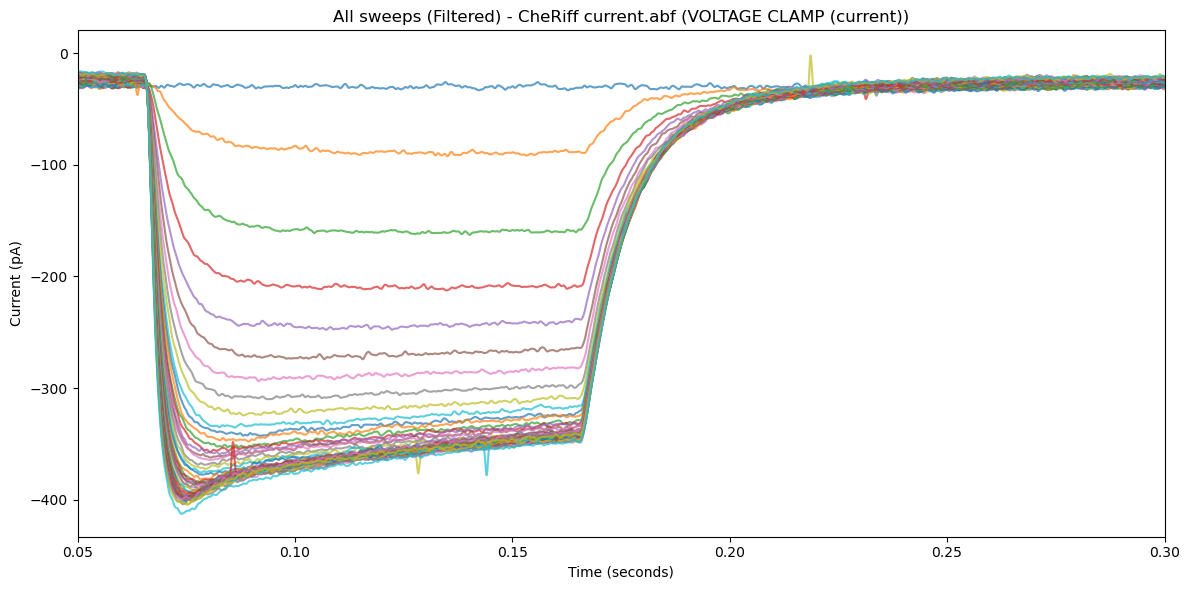

In [10]:
# Plot all sweeps from CheRiff file with optional filtering
if cheriff_file is not None:
    # Optional: Apply lowpass Bessel filter
    apply_filter = True  # Set to False to disable filtering
    
    # Optional: Set time range for plotting (in seconds)
    # Set to None to plot the entire sweep
    time_start = 0.05  # Start time in seconds (e.g., 0.1)
    time_end = 0.3    # End time in seconds (e.g., 0.5)
    
    # Prepare filter if enabled
    if apply_filter:
        fs = abf_cheriff.dataRate
        b_lowpass, a_lowpass = signal.bessel(
            4,        # Order of the filter
            1000,     # Cutoff frequency (adjust as needed - lower = more smoothing)
            'low',    # Type of filter
            analog=False,
            norm='phase',
            fs=fs
        )
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot all sweeps
    for sweepNumber in abf_cheriff.sweepList:
        abf_cheriff.setSweep(sweepNumber)
        time = abf_cheriff.sweepX
        y_variable = abf_cheriff.sweepY
        
        # Apply filter if enabled
        if apply_filter:
            signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, y_variable)
        else:
            signal_filtered = y_variable
        
        # Plot filtered signal
        ax.plot(time, signal_filtered, alpha=0.7, label=f'Sweep {sweepNumber}')
    
    ax.set_xlabel(abf_cheriff.sweepLabelX)
    ax.set_ylabel(cheriff_label)
    
    # Apply time range if specified
    if time_start is not None or time_end is not None:
        ax.set_xlim(time_start, time_end)
    
    filter_status = "Filtered" if apply_filter else "Raw"
    ax.set_title(f'All sweeps ({filter_status}) - {os.path.basename(cheriff_file)} ({cheriff_mode})')
    
    # Add legend only if there are 10 or fewer sweeps
    if abf_cheriff.sweepCount <= 10:
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("CheRiff file not loaded. Please run the previous cell first.")


### 6.2. SOLUTION: Dose-Response Plot (Min Current vs Irradiance)

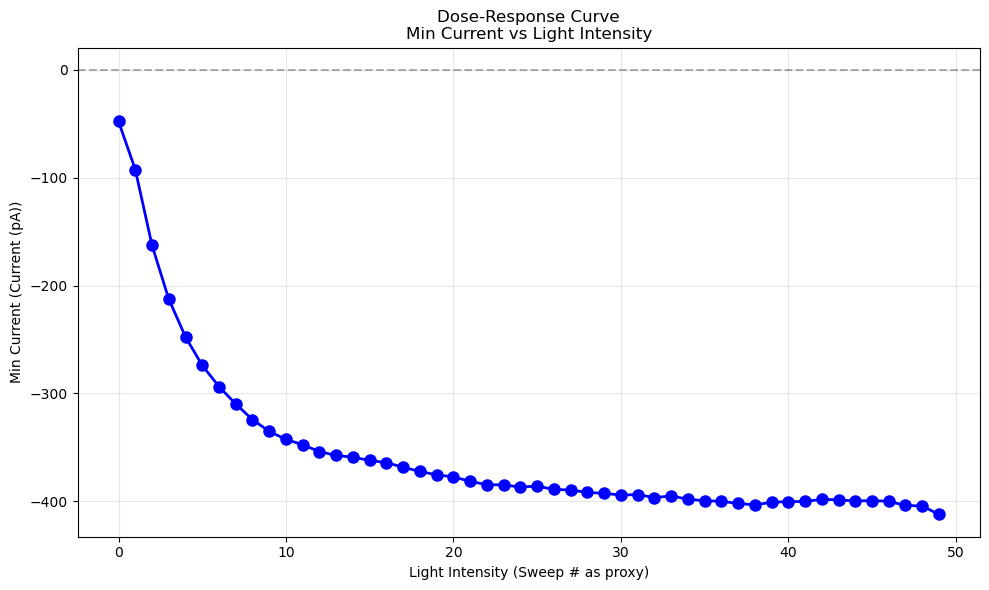


Dose-Response Statistics:
  Peak Response: -412.39 pA
  Weakest Response: -47.78 pA
  Mean Response: -355.47 pA
  Response Range: -364.62 pA

Note: In a real experiment, you would have actual irradiance values
      instead of using sweep numbers as a proxy.


In [19]:
# Calculate minimum current for each sweep (most negative value)
# IMPORTANT: Use filtered signal for accurate measurements!
if cheriff_file is not None:
    min_currents = []
    sweep_numbers = []
    
    # Create filter (same as used in section 6.1)
    fs = abf_cheriff.dataRate
    b_low, a_low = signal.bessel(4, 1000, 'low', analog=False, norm='phase', fs=fs)
    
    for sweepNumber in abf_cheriff.sweepList:
        abf_cheriff.setSweep(sweepNumber)
        
        # **Filter the signal BEFORE measuring!**
        current_filtered = signal.filtfilt(b_low, a_low, abf_cheriff.sweepY)
        
        # Find the minimum (most negative) current from filtered signal
        min_current = np.min(current_filtered)
        min_currents.append(min_current)
        sweep_numbers.append(sweepNumber)
    
    # Create dose-response plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot min current vs sweep number (sweep number is proxy for light intensity)
    ax.plot(sweep_numbers, min_currents, 'o-', linewidth=2, markersize=8, color='blue')
    
    ax.set_xlabel('Light Intensity (Sweep # as proxy)')
    ax.set_ylabel(f'Min Current ({cheriff_label})')
    ax.set_title('Dose-Response Curve\nMin Current vs Light Intensity')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nDose-Response Statistics:")
    print(f"  Peak Response: {np.min(min_currents):.2f} pA")
    print(f"  Weakest Response: {np.max(min_currents):.2f} pA")
    print(f"  Mean Response: {np.mean(min_currents):.2f} pA")
    print(f"  Response Range: {np.min(min_currents) - np.max(min_currents):.2f} pA")
    print("\nNote: In a real experiment, you would have actual irradiance values")
    print("      instead of using sweep numbers as a proxy.")


### 6.3. SOLUTION: Identifying non-light-dependent currents

**Analysis:**

Looking at the CheRiff photocurrent traces, we can identify several types of currents:

1. **Light-dependent current**: The main downward deflection during the light pulse
   - This is the photocurrent we're primarily interested in
   - Shows dose-dependent response (increases with light intensity)

2. **Capacitive transient**: The sharp spike at light onset/offset
   - Caused by charging/discharging of the cell membrane capacitance
   - NOT light-dependent - it's an artifact of voltage-clamp recording
   - Can be minimized with proper capacitance compensation

3. **Leak current**: Steady baseline current
   - Present even without light stimulation
   - NOT light-dependent
   - Can be subtracted using P/N protocols

4. **Tail current**: Current after light offset
   - Shows the kinetics of channel closing
   - Partially light-dependent (caused by channels that were opened by light)

To properly isolate the light-dependent photocurrent, you would typically:
- Use leak subtraction (P/N protocol)
- Apply capacitance compensation
- Measure the sustained photocurrent (not the transient spikes)


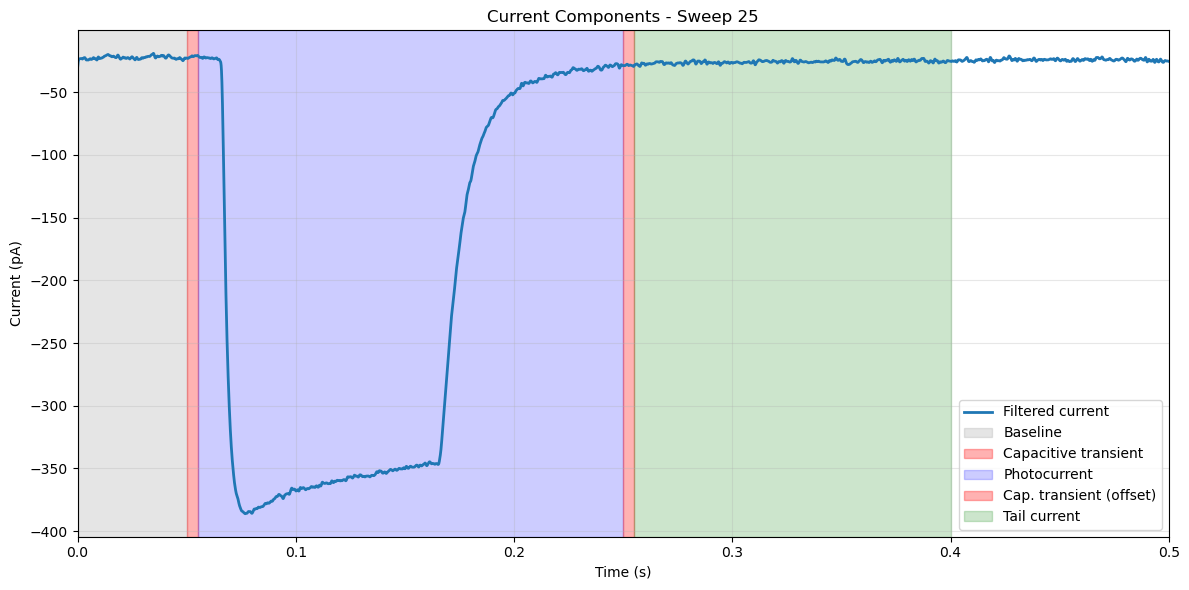


Current Components Identified:
1. Baseline: Holding current before stimulation
2. Capacitive transient: Sharp spike at light ON (artifact)
3. Photocurrent: Main light-evoked current (our signal of interest)
4. Capacitive transient: Sharp spike at light OFF (artifact)
5. Tail current: Deactivation kinetics after light offset


In [12]:
# Demonstrate different current components in a single sweep
if cheriff_file is not None:
    sweep_to_analyze = 25  # Pick a sweep with good photocurrent
    
    abf_cheriff.setSweep(sweep_to_analyze)
    time = abf_cheriff.sweepX
    current = abf_cheriff.sweepY
    
    # Apply filter for cleaner visualization
    fs = abf_cheriff.dataRate
    b_low, a_low = signal.bessel(4, 1000, 'low', analog=False, norm='phase', fs=fs)
    current_filtered = signal.filtfilt(b_low, a_low, current)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the trace
    ax.plot(time, current_filtered, linewidth=2, label='Filtered current')
    
    # Mark different regions (adjust these times based on your protocol)
    ax.axvspan(0, 0.05, alpha=0.2, color='gray', label='Baseline')
    ax.axvspan(0.05, 0.055, alpha=0.3, color='red', label='Capacitive transient')
    ax.axvspan(0.055, 0.25, alpha=0.2, color='blue', label='Photocurrent')
    ax.axvspan(0.25, 0.255, alpha=0.3, color='red', label='Cap. transient (offset)')
    ax.axvspan(0.255, 0.4, alpha=0.2, color='green', label='Tail current')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(cheriff_label)
    ax.set_title(f'Current Components - Sweep {sweep_to_analyze}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCurrent Components Identified:")
    print("1. Baseline: Holding current before stimulation")
    print("2. Capacitive transient: Sharp spike at light ON (artifact)")
    print("3. Photocurrent: Main light-evoked current (our signal of interest)")
    print("4. Capacitive transient: Sharp spike at light OFF (artifact)")
    print("5. Tail current: Deactivation kinetics after light offset")


## 7. Export summary statistics (optional)


In [13]:
# Create a summary dataframe for all files
if len(abf_files) > 0:
    summary_data = []
    
    for abf_file in abf_files:
        abf = pyabf.ABF(abf_file)
        
        for sweepNumber in abf.sweepList:
            abf.setSweep(sweepNumber)
            
            summary_data.append({
                'Filename': os.path.basename(abf_file),
                'Sweep': sweepNumber,
                'Duration_s': abf.sweepLengthSec,
                'Sampling_Rate_Hz': abf.dataRate,
                'Mean': np.mean(abf.sweepY),
                'Std': np.std(abf.sweepY),
                'Min': np.min(abf.sweepY),
                'Max': np.max(abf.sweepY),
                'Units': abf.sweepUnitsY
            })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Optionally save to CSV
    # summary_df.to_csv('analysis_summary.csv', index=False)
    # print("\nSummary saved to 'analysis_summary.csv'")



Summary Statistics:
           Filename  Sweep  Duration_s  Sampling_Rate_Hz       Mean        Std         Min        Max Units
Spike recording.abf      0         1.0             10000 -78.915840   0.415246  -80.566406 -76.904297    pA
Spike recording.abf      1         1.0             10000 -78.626038   1.179641  -79.956055 -69.580078    pA
Spike recording.abf      2         1.0             10000 -77.271240   1.885597  -78.735352 -62.255859    pA
Spike recording.abf      3         1.0             10000 -77.070679   2.517794  -78.735352 -57.373047    pA
Spike recording.abf      4         1.0             10000 -77.990715   2.998609  -79.956055 -54.321289    pA
Spike recording.abf      5         1.0             10000 -78.433289   3.404448  -80.566406 -51.269531    pA
Spike recording.abf      6         1.0             10000 -77.810303   3.828922  -79.956055 -48.217773    pA
Spike recording.abf      7         1.0             10000 -77.813240   4.559162  -79.956055 -44.555664    pA
Spike r

In [14]:
# Your additional analysis code here
